# Vision Transformer (ViT)

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    TensorDataset,
    SequentialSampler,
    random_split,
)
from torch import optim
from torch.nn import functional as F
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor

from typing import Any, Dict, List, Tuple

from tqdm import tqdm

import time

import datasets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

import warnings

warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Available GPU devices: {torch.cuda.device_count()}")
    print(f"Used GPU device: {torch.cuda.get_device_name()}")

else:
    print("There are no GPU available")
    device = torch.device("cpu")

Available GPU devices: 1
Used GPU device: NVIDIA GeForce RTX 3070 Ti


In [3]:
MODEL_NAME = "google/vit-base-patch16-224"

In [4]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

In [5]:
image_info_df = pd.read_csv("../image_sentiment_data.csv")
image_info_df["image_path"] = image_info_df["image_path"].apply(lambda x: "../" + str(x))
image_info_df.head()

,image_path,sentiment
0,../data/preprocess_images/positive/104505632.jpg,positive
1,../data/preprocess_images/positive/1059249846.jpg,positive
2,../data/preprocess_images/positive/108501238.jpg,positive
3,../data/preprocess_images/positive/1089046474.jpg,positive
4,../data/preprocess_images/positive/1096822187.jpg,positive


In [6]:
label_encoder = LabelEncoder()
image_info_df["sentiment"] = label_encoder.fit_transform(image_info_df["sentiment"])

In [7]:
train_images, test_images = train_test_split(image_info_df, test_size=0.2)

In [8]:
train_images.head()

,image_path,sentiment
2765,../data/preprocess_images/negative/5199420821.jpg,0
1841,../data/preprocess_images/neutral/6273105886.jpg,1
1714,../data/preprocess_images/neutral/5365266677.jpg,1
2030,../data/preprocess_images/negative/2177517859.jpg,0
2927,../data/preprocess_images/negative/5717054575.jpg,0


In [9]:
example_image = Image.open(train_images.iloc[0].image_path)
print(f"Input image shape: {np.array(example_image).shape}")
print(f"Features shape: {feature_extractor(example_image, return_tensors='pt').get('pixel_values').shape}")

Input image shape: (256, 256, 3)
Features shape: torch.Size([1, 3, 224, 224])


In [10]:
train_image_info_dataset = datasets.Dataset.from_pandas(train_images, preserve_index=False)
test_image_info_dataset = datasets.Dataset.from_pandas(test_images, preserve_index=False)

In [11]:
def load_and_process_image(image_path: str) -> Dict[str, Any]:
    image_ = Image.open(image_path)
    features = feature_extractor(image_, return_tensors="pt")
    return features

In [12]:
load_and_process_image(train_image_info_dataset[0]["image_path"])

{'pixel_values': tensor([[[[-0.3098, -0.2863, -0.2549,  ..., -0.2314, -0.2392, -0.2235],
          [-0.3176, -0.2941, -0.2863,  ..., -0.2392, -0.2549, -0.2471],
          [-0.3333, -0.3098, -0.2941,  ..., -0.2471, -0.2627, -0.2706],
          ...,
          [-0.9529, -0.9529, -0.9373,  ..., -0.9529, -0.9843, -0.9922],
          [-0.8902, -0.8510, -0.8980,  ..., -0.8588, -0.9216, -0.9608],
          [-0.9608, -0.9608, -0.9373,  ..., -0.9216, -0.9451, -0.9216]],

         [[ 0.2471,  0.2706,  0.2941,  ...,  0.2784,  0.2627,  0.2784],
          [ 0.2549,  0.2706,  0.2784,  ...,  0.2863,  0.2706,  0.2627],
          [ 0.2627,  0.2706,  0.2784,  ...,  0.2784,  0.2627,  0.2549],
          ...,
          [-0.2549, -0.1922, -0.1373,  ..., -0.2000, -0.2000, -0.2078],
          [-0.1529, -0.0275, -0.0353,  ..., -0.0353, -0.0902, -0.1216],
          [-0.1059, -0.0588, -0.0196,  ..., -0.0431, -0.0667, -0.0588]],

         [[ 0.5765,  0.6000,  0.6235,  ...,  0.6314,  0.6235,  0.6471],
          [ 0

In [13]:
def preprocess_dataset(image_paths: List[str]) -> torch.Tensor:
    pixel_values = []
    for image_path in tqdm(image_paths):
        pixel_values.append(load_and_process_image(image_path).get("pixel_values"))
    return torch.cat(pixel_values, dim=0)

In [14]:
train_pixel_values = preprocess_dataset(train_image_info_dataset["image_path"])
train_labels = F.one_hot(torch.tensor(train_image_info_dataset["sentiment"]).to(torch.int64)).to(torch.float64)
test_pixel_values = preprocess_dataset(test_image_info_dataset["image_path"])
test_labels = F.one_hot(torch.tensor(test_image_info_dataset["sentiment"]).to(torch.int64)).to(torch.float64)

100%|██████████| 651/651 [00:13<00:00, 47.32it/s]


In [15]:
train_data = TensorDataset(train_pixel_values, train_labels)
test_data = TensorDataset(test_pixel_values, test_labels)

train_size = int(0.6 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size])

In [16]:
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
valid_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)
test_dataloader = DataLoader(test_data)

In [17]:
vit_model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_encoder.classes_),
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
torch.cuda.empty_cache()

In [19]:
vit_model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [20]:
def f1_weighted_score(preds: torch.Tensor, labels: torch.Tensor):
    pred_numpy = preds.cpu().detach().numpy()
    labels_numpy = labels.cpu().detach().numpy()
    pred_flatten = np.argmax(pred_numpy, axis=1).flatten()
    labels_flatten = np.argmax(labels_numpy, axis=1).flatten()
    return f1_score(labels_flatten.astype(np.int32), pred_flatten.astype(np.int32), average="weighted")

In [21]:
def train(
    model: torch.nn.Module,
    dataloader: DataLoader,
    optim: optim.Optimizer,
    loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.train()
    for image, sentiment in dataloader:
        optim.zero_grad()

        image = image.to(device)
        sentiment = sentiment.to(device)

        preds = model(image).logits

        loss_current = loss_func(preds.to(device), sentiment)

        accuracy_curr = f1_weighted_score(preds, sentiment)

        loss_current.backward()
        optim.step()

        loss += loss_current.item()
        accuracy += accuracy_curr.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [22]:
def validate(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for image, sentiment in dataloader:
            image = image.to(device)
            sentiment = sentiment.to(device)

            preds = model(image).logits

            loss_current = loss_func(preds.to(device), sentiment)

            accuracy_current = f1_weighted_score(preds, sentiment)

            loss += loss_current.item()
            accuracy += accuracy_current.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [23]:
def training(
    model: torch.nn.Module,
    train_data: DataLoader,
    validate_data: DataLoader,
    optim: optim.Optimizer,
    loss_func: torch.nn.Module,
    num_epochs: int = 10,
) -> Dict[str, Any]:
    best_loss = float('inf')
    history = {
        "train": {
            "loss": [],
            "accuracy": [],
        },
        "valid": {
            "loss": [],
            "accuracy": [],
        }
    }
    for epoch in range(num_epochs):
        print(f"{'=' * 15} Epoch: {epoch + 1} {'=' * 15}")
        time_start = time.time()
        train_loss, train_accuracy = train(model, train_data, optim, loss_func)
        print(f"Train: loss={train_loss:.3f}, accuracy={train_accuracy:.3f}")
        validation_loss, validation_accuracy = validate(model, validate_data, loss_func)
        print(f"Validation: loss={validation_loss:.3f}, accuracy={validation_accuracy:.3f}")
        time_end = time.time()
        time_delta = time_end - time_start
        if validation_loss < best_loss:
            best_loss = validation_loss
        history["train"]["accuracy"].append(train_accuracy)
        history["train"]["loss"].append(train_loss)
        history["valid"]["accuracy"].append(validation_accuracy)
        history["valid"]["loss"].append(validation_loss)
        print(f"Time elapsed: {time_delta:.2f} s\n{'=' * 40}")
    return history

In [24]:
import matplotlib.pyplot as plt


def plot_history(history: dict) -> None:
    train = history.get("train")
    valid = history.get("valid")
    plt.title("Loss")
    plt.plot(train.get("loss"), label="train")
    plt.plot(valid.get("loss"), label="valid")
    plt.legend()
    plt.show()
    plt.title("Accuracy")
    plt.plot(train.get("accuracy"), label="train")
    plt.plot(valid.get("accuracy"), label="valid")
    plt.legend()
    plt.show()

In [25]:
optimizer = optim.AdamW(vit_model.parameters(), lr=2e-6, eps=1e-8)
loss_function = torch.nn.CrossEntropyLoss().to(device)

In [26]:
vit_history = training(
    vit_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_function,
    num_epochs=20,
)

=============== Epoch: 1 ===============
Train: loss=1.063, accuracy=0.454
Validation: loss=1.031, accuracy=0.469
Time elapsed: 75.19 s
=============== Epoch: 2 ===============
Train: loss=0.969, accuracy=0.520
Validation: loss=0.980, accuracy=0.531
Time elapsed: 26.76 s
=============== Epoch: 3 ===============
Train: loss=0.904, accuracy=0.567
Validation: loss=0.946, accuracy=0.573
Time elapsed: 26.21 s
=============== Epoch: 4 ===============
Train: loss=0.849, accuracy=0.602
Validation: loss=0.917, accuracy=0.602
Time elapsed: 26.68 s
=============== Epoch: 5 ===============
Train: loss=0.797, accuracy=0.639
Validation: loss=0.893, accuracy=0.616
Time elapsed: 26.40 s
=============== Epoch: 6 ===============
Train: loss=0.753, accuracy=0.664
Validation: loss=0.871, accuracy=0.622
Time elapsed: 26.49 s
=============== Epoch: 7 ===============
Train: loss=0.709, accuracy=0.690
Validation: loss=0.852, accuracy=0.634
Time elapsed: 26.39 s
=============== Epoch: 8 ===============
Train: 

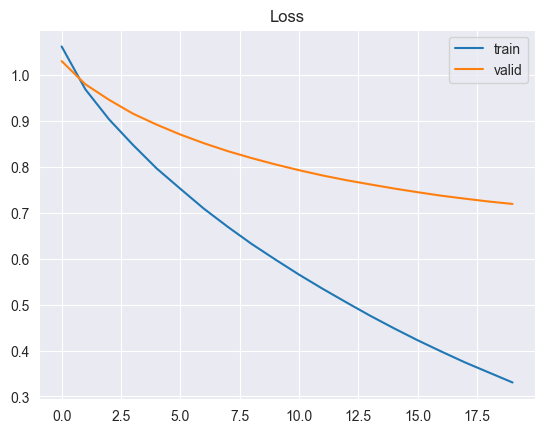

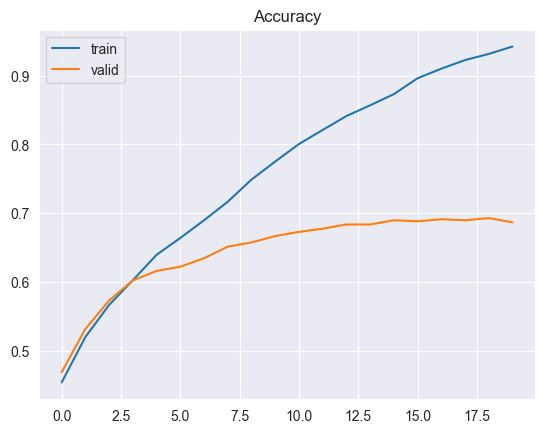

In [27]:
plot_history(vit_history)